In [1]:
import pandas as pd
import numpy as np
from gammapy.data import DataStore
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import Background2D, Background3D
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis,WcsNDMap, WcsGeom

from copy import deepcopy
import seaborn as sns

from regions import CircleSkyRegion, CircleAnnulusSkyRegion
from astropy.convolution import convolve_fft, Gaussian2DKernel

sns.set_theme(font="Serif",style='ticks',context='talk',palette='pastel')

In [2]:
datastore = DataStore.from_dir("/raid/romulus/dl3/ed/dl3_fullenclosure_moderate2tel/")
obs_table = datastore.obs_table
obs_table = obs_table.to_pandas()

In [3]:
grouped = obs_table.groupby(['OBJECT'])['LIVETIME'].agg('sum')/60
grouped = grouped.sort_values()

In [4]:
drop_list= [b'Crab', b'Mrk421', b'Mrk501',b'MGRO J1908+06 centro',b'Boomerang',b'Sgr A*',b'Sgr A* Off',b'IC443 Hot Spot',b'Gamma Cygni',b'M31',b'LS I +61 303',b'VER J0521+211']

filtered = grouped.drop(drop_list)

In [5]:
def load_exclusion_regions(exclusion_file='VTSCat.csv'):
    """
        Calculate a radial acceptance map

        Parameters
        ----------
        exclusion_file : Path to csv file with coordinates of sources in RA/DEC

        Returns
        -------
        exclusion_regions_vts : list of regions.shapes.circle.CircleSkyRegion
            A list of exclusion regions
    """

    # load VTSCat "catalog"
    VTSCat = pd.read_csv(exclusion_file)
    VTSCat.rename(columns={'pos_ra': 'RA', 'pos_dec': 'DEC', 'common_name': 'Source_Name'}, inplace=True)
    VTSCat[['RA', 'DEC']]
    VTSCat = VTSCat.loc[VTSCat['source_id'] < 100000]  ### only detected sources
    VTSCat['position'] = SkyCoord(VTSCat['RA'], VTSCat['DEC'], unit="deg", frame="icrs")
    ## VTS Cat generated exclusion regions with 0.3° radius, currently 84 known sources
    exclusion_radius = Angle("0.3 deg")
    exclusion_regions_vts = [(VTSCat['RA'][i],VTSCat['DEC'][i], exclusion_radius.value) for i in range(len(VTSCat))]
    return exclusion_regions_vts

In [6]:
exclusion_regions = load_exclusion_regions('./VTSCat.csv')


In [7]:
runlist = obs_table[obs_table['OBJECT'].isin(filtered.index)]


In [8]:
class BackgroundModelEstimator:
    
    def __init__(self,
        energy, 
        offset,
        excluded_sources,
        smooth,
        smooth_sigma: float = 1,):

        self.excluded_sources = excluded_sources
        self.smooth = smooth
        self.smooth_sigma = smooth_sigma
        self.counts = self._make_bkg2d(energy, offset, unit="")
        self.exposure = self._make_bkg2d(energy, offset, unit="s TeV sr")
        #self.exclusion = ExclusionFinder()
    @staticmethod
    def _make_bkg2d(energy, offset, unit):
        return Background2D(axes=[energy, offset], unit=unit)

    def run(self, observations):
        for obs in observations:
            counts, exposure = self.fill_counts(obs)
            self.counts.data += counts
            self.exposure.quantity += exposure

    def fill_counts(self, obs):
        energy, offset = self.counts.axes
        run_ra = obs.pointing.fixed_icrs.ra.deg
        run_dec = obs.pointing.fixed_icrs.dec.deg
        events = obs.events
        events.table['offset'] = events.offset.to("deg")
        #display(events.table)

        events = MapDatasetEventSampler.event_det_coords(obs, events)
        run_mask = np.ones(len(events.table), dtype=bool)
        for reg in self.excluded_sources:
            run_mask &= ((events.table["RA"] - reg[0]) ** 2 + (events.table["DEC"] - reg[1]) ** 2) > reg[2] ** 2
        counts = np.histogram2d(
            events.energy[~run_mask].to('TeV'), events.offset.to("deg")[~run_mask],
            (energy.edges, offset.edges))[0]  
        self.counts.data += counts
        counts_all = np.histogram(events.offset.to("deg"), bins=offset.edges)[0] + 1e-9
        # Only kept events
        counts_exc = (
            np.histogram(events.offset[~run_mask].to("deg"), bins=offset.edges)[0] + 1e-9
        )

        axes = self.exposure.axes
        offset = axes["offset"].center
        time = obs.observation_time_duration
        exposure = 2 * np.pi * offset * time * axes.bin_volume()

        # Scale exposure by fraction of events accepted
        # self.exposure.quantity += exposure * (counts_exc / counts_all)
        return counts, exposure * (counts_exc / counts_all)

    @property
    def background_rate(self):
        rate = deepcopy(self.counts)
        rate.quantity /= self.exposure.quantity
        if self.smooth:
            rate = smooth_convolve(rate, sigma=self.smooth_sigma)
        return rate
    @property
    def background_rate_error(self):
        rate = deepcopy(self.counts)
        err = np.sqrt(rate.quantity)
        err /= self.exposure.quantity
        
        return err

def smooth(bkg: Background2D, sigma: float = 1.0) -> Background2D:
    bkg_3d = bkg.to_3d()
    for i in range(len(bkg_3d.data)):
        smoothed = gaussian_filter(bkg_3d.data[i, :, :], sigma, 0)
        bkg_3d.data[i, :, :] = smoothed
    return bkg_3d.to_2d()

def smooth_convolve(bkg,sigma=1.0):
    bkg_3d = bkg.to_3d()
    for i in range(len(bkg_3d.data)):
        data = bkg_3d.data[i, :, :] # evaluate at one energy for now
        padded_data = np.pad(data,10)
        window1d = np.abs(np.blackman(len(padded_data)))
        window2d = np.sqrt(np.outer(window1d,window1d))
        windowed = padded_data * window2d
        gauss = Gaussian2DKernel(sigma,sigma,x_size=np.shape(windowed)[0],y_size=np.shape(windowed)[1])

        #conv = convolve_fft(windowed,gauss,normalize_kernel=False)
        conv = convolve_fft(data,gauss,normalize_kernel=False,fft_pad=True,preserve_nan=True)
        #conv = conv[10:-10,10:-10]
        bkg_3d.data[i, :, :] = conv
    return bkg_3d.to_2d()

In [70]:
emin = 0.01
emax = 100
ebins = 10

energy = MapAxis.from_energy_bounds(
    emin*u.TeV,
    emax*u.TeV,
    ebins,
    name="energy",
    unit="TeV",
)

offset = MapAxis.from_bounds(
    0*u.deg,
    2.5*u.deg,
    nbin=25,
    interp="lin",
    unit="deg",
    name="offset",
)

In [71]:
estimator = BackgroundModelEstimator(
                energy,
                offset,
                smooth=False,
                smooth_sigma=1,
                excluded_sources=exclusion_regions
            )

In [72]:
zeniths = [(0,10),(10,20),(20,30),(30,40),(40,45),(45,50),(50,55),(55,60)]
azimuths = [(-90,90),(90,270)]

epochs = {
        "V4": {"tstart": Time("2000-01-01"), "tstop": Time("2009-09-13")},
        "V5": {"tstart": Time("2009-09-14"), "tstop": Time("2012-07-31")},
        "V6_2012_2013a": {"tstart": Time("2012-08-01"), "tstop": Time("2013-03-15")},
        "V6_2012_2013b": {"tstart": Time("2013-03-16"), "tstop": Time("2013-11-16")},
        "V6_2013_2014a": {"tstart": Time("2013-11-17"), "tstop": Time("2014-05-12")},
        "V6_2013_2014b": {"tstart": Time("2014-05-13"), "tstop": Time("2014-11-07")},
        "V6_2014_2015": {"tstart": Time("2014-11-08"), "tstop": Time("2015-07-31")},
        "V6_2015_2016": {"tstart": Time("2015-08-01"), "tstop": Time("2016-07-31")},
        "V6_2016_2017": {"tstart": Time("2016-08-01"), "tstop": Time("2017-07-31")},
        "V6_2017_2018": {"tstart": Time("2017-08-01"), "tstop": Time("2018-07-31")},
        "V6_2018_2019": {"tstart": Time("2018-08-01"), "tstop": Time("2019-11-12")},
        "V6_2019_2020w": {"tstart": Time("2019-11-13"), "tstop": Time("2020-05-07")},
        "V6_2020_2020s": {"tstart": Time("2020-05-08"), "tstop": Time("2020-11-04")},
        "V6_2020_2021w": {"tstart": Time("2020-11-05"), "tstop": Time("2021-04-27")},
        "V6_2021_2021s": {"tstart": Time("2021-04-28"), "tstop": Time("2021-11-16")},
        "V6_2021_2022w": {"tstart": Time("2021-11-17"), "tstop": Time("2022-05-09")},
        #  "V6_2022_2022s" : {"tstart"  :Time("2022-05-10"), "tstop" : Time("2022-11-08")},
        "V6_2022_2022s": {"tstart": Time("2022-05-10"), "tstop": Time("2025-11-08")},
    }

In [73]:
epoch = "V6_2012_2013a"
az = azimuths[0]
ze = zeniths[0]

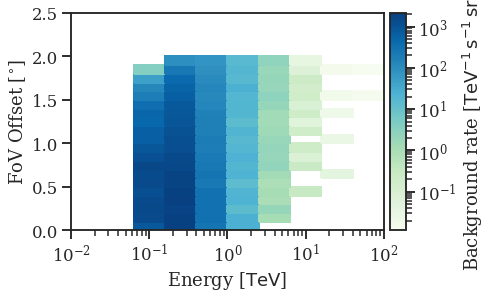

In [74]:
tstart = epochs[epoch]['tstart']
tstop = epochs[epoch]['tstop']
date = runlist['DATE-OBS'].astype('str')
dates = Time(np.array(date.values.astype('str')),format='isot',scale='utc')
mask = (runlist['ZEN_PNT'] >= ze[0]) & (runlist['ZEN_PNT'] < ze[1]) & (runlist['AZ_PNT'] >= az[0])& (runlist['AZ_PNT'] < az[1])&(dates > tstart) & (dates < tstop)
observations = datastore.get_observations(obs_id=runlist[mask]['OBS_ID'])
estimator.run(observations)
bkg_rate = estimator.background_rate
bkg_err = estimator.background_rate_error
bkg_rate.plot()
plt.show()

In [75]:
energy = bkg_rate.axes['energy']
energy.center

<Quantity [1.58489319e-02, 3.98107171e-02, 1.00000000e-01, 2.51188643e-01,
           6.30957344e-01, 1.58489319e+00, 3.98107171e+00, 1.00000000e+01,
           2.51188643e+01, 6.30957344e+01] TeV>

Text(0.5, 0, 'Offset')

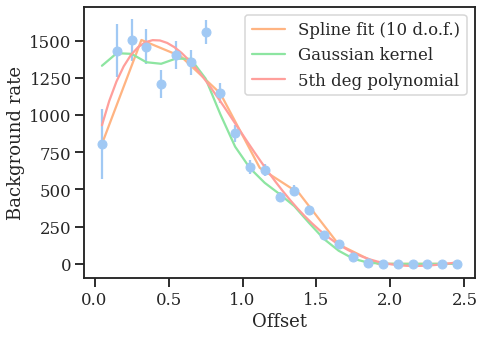

In [76]:
from scipy.interpolate import splrep, splev
data = bkg_rate.data[2, :] # evaluate at one energy for now
data = data#/max(data)
offset = bkg_rate.axes['offset'].center.value
smooth_offset = np.linspace(offset[0],offset[-1],10)
smoother_offset = np.linspace(offset[0],offset[-1],50)


spline = splrep(offset,data,k=3)
fit = splev(smooth_offset,spline)

gauss = smooth_convolve(bkg_rate,sigma=1)
poly = np.polyfit(offset,data,deg=5)
p = np.poly1d(poly)

plt.figure(figsize=(7,5))
plt.errorbar(offset,data,yerr=bkg_err.value[2,:],marker='o',ls='')

plt.plot(smooth_offset,fit,label='Spline fit (10 d.o.f.)')
plt.plot(offset,gauss.data[2,:],label='Gaussian kernel')
plt.plot(smoother_offset,p(smoother_offset),label='5th deg polynomial')
plt.legend()
plt.ylabel('Background rate')
plt.xlabel('Offset')

In [108]:
offset = bkg_rate.axes['offset']
energy = bkg_rate.axes['energy']

In [109]:
rates3 = []
for o in offset.center:
    rate = bkg_rate.evaluate(offset=o,energy=1*u.TeV)
    rates3.append(rate.value)

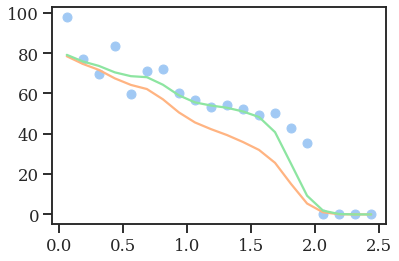

In [110]:
plt.plot(offset.center,rates,'o')
plt.plot(offset.center,rates2)
plt.plot(offset.center,rates3)